# Plot results of relocation of ball drop
2022.11.7 Kurama Okubo

This notebook plots the results of ball drop test and generates the csv table.

- 2024.1.22 rechecked the notebook.
- 2024.4.18 plot waveforms associated with a single ball-drop source
- 2025.3.12 remove the grid search on the velocity to simplify the process for master plot. 

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm, colors
from PIL import Image

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime    
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision

# Parameters

In [2]:
starttime=datetime.datetime(2021,4,8) # Used to unify the dataset

autopick_threshold = 15

channel_finame = '../../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'
balldropid_finame = '../data/balldrop_id.txt'

datadir="../data/DATA_computeCF"
figdir = "../figure/debug_p02_result_computeCF"


In [3]:
if not os.path.exists(figdir):
    os.makedirs(figdir)

## Read channel array

In [4]:
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float') # attention for the direction of y coordinate: positive in anticlockwise
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]


## Read balldrop ids

In [5]:
df_bd = pd.read_csv(balldropid_finame, header = None)
balldrop_ids = df_bd[0].values

In [6]:
balldrop_ids[:1]

array(['BD_0220'], dtype=object)

# Auto-function

In [7]:
for datacase in balldrop_ids[:]:
    print(datacase)
    dataID = datacase.split('_')[1]
    finame = os.path.join(datadir, datacase+".pickle") 

    # read data
    st = read(finame)

    tpick = st.tpick
    PickNumStation = st.PickNumStation
    AEsensor_newloc = st.AEsensor_newloc
    ot = st.origintime

    # store traces for plots
    tpick_sorted = sorted(tpick.items(), key=lambda x: np.inf if np.isnan(x[1]) else x[1], reverse=False) # ignore the nan

    st_pick = Stream()
    for i, (stnm, t1) in enumerate(tpick_sorted[:PickNumStation]):
        if np.isnan(t1):
            # skip this station
            continue;
        print(stnm)
        tr = st.select(station=stnm)[0]
        tr.dist = AEsensor_newloc[stnm][0]
        st_pick.append(tr)

    #tvec with removing offset
    fs = st_pick[0].stats.sampling_rate
    t = st_pick[0].times()*1e3 - ot
#     t = np.arange(0, (st_pick[0].stats.npts-1)/fs, 1/fs)*1e3 - ot  #[ms]

    fig, axs = plt.subplots(8, 1, sharex=True, figsize=(10, 10))
    twin_max = .5 #[ms]
    xlimit = [-0.1, twin_max]
    ylimit = [-0.4, 0.4]
    ylimit_fap = [-10, 50]

    fontsize = 12

    for i in range(4):
        ax1 = axs[2*i]
        ax2 = axs[2*i+1]

        tr = st_pick[i]
        stnm = tr.stats.station
        picktime = tpick[stnm]

        ax1.plot(t, tr.data*1e3, 'k-', label=stnm)#, marker=".", ms=8)
        ax1.axvline(picktime-ot, color='r', ls='--')
        ax1.set_xlim(xlimit)
        ax1.set_ylim(ylimit)
        ax1.tick_params(direction='in')
        ax1.set_ylabel("[mm/s]", fontsize=fontsize)
        ax1.text(xlimit[0]+1e-2, ylimit[0]+0.2, "dist={0:<.0f}mm".format(tr.dist), fontsize=12)

        ax1.legend(loc=2)

        ax2.plot(t, tr.fap, 'k') #, marker=".", ms=8)
        ax2.axvline(picktime-ot, color='r', ls='--')
        ax2.axhline(autopick_threshold, color='k', ls='--')
        ax2.tick_params(direction='in')
        ax2.set_ylabel("$F_i$", fontsize=fontsize)
        ax2.set_yticks([0, autopick_threshold, ylimit_fap[-1]])
        ax2.set_ylim(ylimit_fap)

    fig.text(0.5, 0.89, "{} fs={}MHz no filtered".format(datacase, fs/1e6), ha='center', fontsize=fontsize)
    plt.xlabel("Time [ms]", fontsize=fontsize)

    plt.savefig(figdir+"/autopickfunc_{}.png".format(datacase), format="png", dpi=150)

    plt.close()
    plt.clf()

BD_0220
OL01
OL17
OL02
OL18
BD_0340
OL17
OL02
OL01
OL18
BD_0460
OL02
OL18
OL17
OL03
BD_0580
OL18
OL03
OL02
OL19
BD_0700
OL03
OL19
OL18
OL04
BD_0820
OL19
OL04
OL03
OL20
BD_0940
OL04
OL20
OL19
OL05
BD_1060
OL20
OL05
OL04
OL21
BD_1180
OL05
OL21
OL20
OL06
BD_1300
OL21
OL06
OL05
OL22
BD_1420
OL06
OL22
OL21
OL07
BD_1540
OL22
OL07
OL06
OL23
BD_1660
OL07
OL22
OL23
OL08
BD_1780
OL23
OL07
OL08
OL22
BD_1900
OL08
OL23
OL24
OL07
BD_2020
OL24
OL08
OL09
OL23
BD_2140
OL09
OL24
OL25
OL08
BD_2260
OL25
OL09
OL10
OL24
BD_2380
OL10
OL25
OL26
OL09
BD_2500
OL26
OL10
OL11
OL25
BD_2620
OL11
OL26
OL27
OL10
BD_2740
OL27
OL11
OL12
OL26
BD_2860
OL12
OL27
OL28
OL11
BD_2980
OL28
OL12
OL13
OL27
BD_3100
OL28
OL13
OL12
OL29
BD_3220
OL13
OL29
OL28
OL14
BD_3340
OL29
OL14
OL13
OL30
BD_3460
OL14
OL30
OL29
OL15
BD_3580
OL30
OL15
OL14
OL31
BD_3700
OL15
OL31
OL30
OL16
BD_3820
OL31
OL16
OL15
OL32
BD_3940
OL16
OL32
OL31
OL15


<Figure size 640x480 with 0 Axes>

In [8]:
st.origintime

0.08629334640774614

In [9]:
#2021/12/22 debug checking details in autopick location
figdir_debug = "../figure/debug_computeCF"

if not os.path.exists(figdir_debug):
    os.makedirs(figdir_debug)
    
dist_diff_all = []

# for datacase in balldrop_ids[:]:
for datacase in balldrop_ids:
    print(datacase)
    dataID = datacase.split('_')[1]
    finame = os.path.join(datadir, datacase+".pickle") 

    # read data
    st = read(finame)

    tpick = st.tpick
    PickNumStation = st.PickNumStation
    AEsensor_newloc = st.AEsensor_newloc
    ot = st.origintime

    # store traces for plots
    tpick_sorted = sorted(tpick.items(), key=lambda x: np.inf if np.isnan(x[1]) else x[1], reverse=False) # ignore the nan
    print(tpick_sorted)
    
    st_pick = Stream()
    for i, (stnm, t1) in enumerate(tpick_sorted[:PickNumStation]):
        if np.isnan(t1):
            # skip this station
            continue;
        print(stnm)
        tr = st.select(station=stnm)[0]
        tr.dist = AEsensor_newloc[stnm][0]
        st_pick.append(tr)


    #tvec with removing offset
    fs = st_pick[0].stats.sampling_rate
    
    t = st_pick[0].times()*1e3 - ot
#     t = np.arange(0, (st_pick[0].stats.npts-1)/fs, 1/fs)*1e3 - ot  #[ms]

    fig, axs = plt.subplots(8, 1, sharex=False, figsize=(10, 10))
    twin_max = .5 #[ms]
    xlimit = [-0.1, twin_max]
    ylimit = [-1.5, 1.5]
    ylimit_fap = [-10, 50]

    fontsize = 12

    for i in range(4):
        ax1 = axs[2*i]
        ax2 = axs[2*i+1]

        tr = st_pick[i]
        stnm = tr.stats.station
        picktime = tpick[stnm]

        ax1.plot(t*1e3, tr.data*1e3, 'k-', label=stnm, marker="x", ms=8)
        ax1.axvline((picktime-ot)*1e3, color='r', ls='--', label="pick_CF")
        
        #---compute synthetic arrival time---#
        vp = 6200.0#[m/s]
        tarriv_theoretical = tr.dist/vp #[ms]
        ax1.axvline(tarriv_theoretical*1e3, color='b', ls=':', label="pick_theoretical")
        tdiff = (picktime-ot) - tarriv_theoretical
        #----------------------------------------------#
        
        #---plot reference trace expected from simulation---#
        ax1.plot((t-tdiff)*1e3, tr.data*1e3, 'g--', label=stnm+"_ref")
        #----------------------------------------------------------------#
        
        #---Evaluate P wave amplitude---#
        pwin_len = 15e-3 #[ms]
        st_tmp = tr.stats.starttime
#         pt = timedelta(milliseconds = ot)
        ps = timedelta(milliseconds = picktime)
        pw = timedelta(milliseconds = pwin_len)
        starttime_tmp = st_tmp+ps
        endtime_tmp  = st_tmp+ps+pw
        p_max_obs = np.max(tr.copy().trim(starttime_tmp, endtime_tmp).data) # avoid error in multiple trim
        print(starttime_tmp, endtime_tmp, p_max_obs)
        #----------------------------------------#
        
        xlimit_focus = [(picktime-ot)*1e3-5, (picktime-ot)*1e3+pwin_len*1e3]
        print(xlimit_focus)
        ax1.set_xlim(xlimit_focus)
        ax1.set_ylim([-1.3e3*p_max_obs, 1.3e3*p_max_obs])
        ax1.tick_params(direction='in')
        ax1.set_ylabel("[mm/s]", fontsize=fontsize)
#         ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.5))

        ax1.text(xlimit_focus[0]+1, -0.9e3*p_max_obs, "dist={0:<.0f}mm".format(tr.dist), fontsize=12)
        ax1.legend(loc=(1.01,0))
        if i==0:
            ax1.set_title("{} fs={}MHz no filtered".format(datacase, fs/1e6), ha='center', fontsize=fontsize)

        ax2.plot(t*1e3, tr.fap, 'k-+') #, marker=".", ms=8)
        ax2.axvline((picktime-ot)*1e3, color='r', ls='--')
        ax2.axhline(autopick_threshold, color='k', ls='--')
        ax2.tick_params(direction='in')
        ax2.set_ylabel("$F_i$", fontsize=fontsize)
        ax2.set_yticks([0, autopick_threshold, ylimit_fap[-1]])
        ax2.set_xlim(xlimit_focus)
        ax2.set_ylim(ylimit_fap)

#     fig.text(0.5, 0.89, "{} fs={}MHz no filtered".format(datacase, fs/1e6), ha='center', fontsize=fontsize)
    plt.xlabel(r"Time [$\mu$s]", fontsize=fontsize)
   
    plt.tight_layout()
    plt.savefig(figdir_debug+"/autopickfunc_{}_focused.png".format(datacase), format="png", dpi=150)
    
    plt.close()
    plt.clf()

BD_0220
[('OL01', 0.1013), ('OL17', 0.1037), ('OL02', 0.12079999999999999), ('OL18', 0.1391), ('OL03', 0.1553), ('OL19', 0.1778), ('OL04', 0.1976), ('OL20', 0.2924), ('OL21', 0.3033), ('OL22', 0.3457), ('OL05', 0.3688), ('OL06', 0.4164), ('OL07', nan), ('OL08', nan), ('OL09', nan), ('OL10', nan), ('OL11', nan), ('OL12', nan), ('OL13', nan), ('OL14', nan), ('OL15', nan), ('OL16', nan), ('OL23', nan), ('OL24', nan), ('OL25', nan), ('OL26', nan), ('OL27', nan), ('OL28', nan), ('OL29', nan), ('OL30', nan), ('OL31', nan), ('OL32', nan)]
OL01
OL17
OL02
OL18
1970-01-01T00:00:00.00010100Z 1970-01-01T00:00:00.00011600Z 0.00024224962441151063
[9.996305023763146, 29.996305023763146]
1970-01-01T00:00:00.00010400Z 1970-01-01T00:00:00.00011900Z 0.00015295890323990482
[12.396305023763144, 32.39630502376315]
1970-01-01T00:00:00.00012100Z 1970-01-01T00:00:00.00013600Z 1.8017617886003888e-05
[29.496305023763135, 49.496305023763135]
1970-01-01T00:00:00.00013900Z 1970-01-01T00:00:00.00015400Z 1.1964150383

<Figure size 640x480 with 0 Axes>

In [10]:
ot, picktime

(0.08629334640774614, 0.1331)

In [11]:
# #make GIF to check all cases
# files = sorted(glob(figdir+'/autopickfunc_*.png'))
# images = list(map(lambda file : Image.open(file) , files))
# images[0].save(figdir+'/autopickfunc_all.gif' , save_all = True , append_images = images[1:] , duration = 400 , loop = 0)

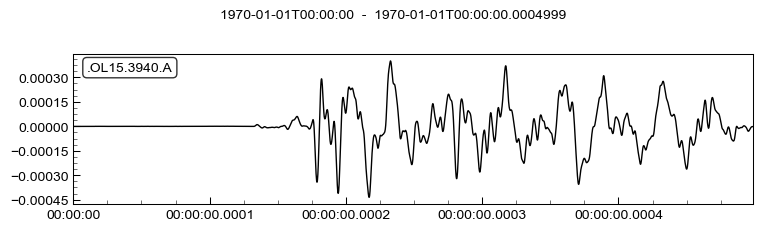

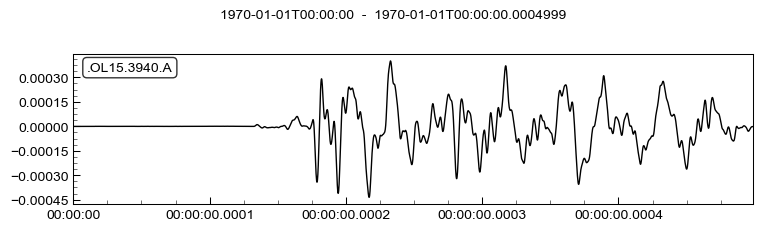

In [12]:
tr.plot()

# Plot all trace with pick time

In [13]:
figdir_pick = "../figure/p02_tracewithpicktime"

if not os.path.exists(figdir_pick):
    os.makedirs(figdir_pick)
    
for datacase in balldrop_ids:
    print(datacase)
    dataID = datacase.split('_')[1]
    finame = os.path.join(datadir, datacase+".pickle") 


    # read data
    st = read(finame)

    tpick = st.tpick
    ot = st.origintime

    #tvec with removing offset
    fs = st_pick[0].stats.sampling_rate
    t = st_pick[0].times()*1e3 - ot
#     t = np.arange(0, (st_pick[0].stats.npts-1)/fs, 1/fs)*1e3 - ot  #[ms]

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    twin_max = 0.4 #[ms]
    xlimit = [0, twin_max]
    ylimit = [-1, 32.5]

    fontsize = 12
    normamp = 3e-4
    yshift = np.arange(0, len(st))
    ylabels = []
    for i, tr in enumerate(st):

        tr = st[i]
        stnm = tr.stats.station
        ylabels.append(stnm)

        picktime = tpick[stnm]
        ax.plot(t, tr.data/normamp + yshift[i], 'k-')
        ax.plot([picktime-ot, picktime-ot], [yshift[i]-0.5, yshift[i]+0.5],  color='r', ls='-', zorder=10)


    ax.set_xlim(xlimit)
    ax.set_ylim(ylimit)
    ax.tick_params(direction='in')
    ax.set_yticks(yshift)
    ax.set_yticklabels(ylabels, fontsize=fontsize)
    ax.set_xlabel("Time [ms]", fontsize=fontsize)
#     plt.gca().invert_yaxis()


    ax.set_title("{} fs={}MHz no filtered".format(datacase, fs/1e6), fontsize=fontsize)

    plt.savefig(figdir_pick+"/alltraces_{}.png".format(datacase), format="png", dpi=70)
    plt.clf()
    plt.close()

BD_0220
BD_0340
BD_0460
BD_0580
BD_0700
BD_0820
BD_0940
BD_1060
BD_1180
BD_1300
BD_1420
BD_1540
BD_1660
BD_1780
BD_1900
BD_2020
BD_2140
BD_2260
BD_2380
BD_2500
BD_2620
BD_2740
BD_2860
BD_2980
BD_3100
BD_3220
BD_3340
BD_3460
BD_3580
BD_3700
BD_3820
BD_3940


In [14]:
# #make GIF to check all cases
# files = sorted(glob(figdir_pick+'/alltraces_*.png'))
# images = list(map(lambda file : Image.open(file) , files))
# images[0].save(figdir_pick+'/alltraces_all.gif' , save_all = True , append_images = images[1:] , duration = 400 , loop = 0)

# Plot waveforms with single ball drop source

In [15]:
balldrop_ids

array(['BD_0220', 'BD_0340', 'BD_0460', 'BD_0580', 'BD_0700', 'BD_0820',
       'BD_0940', 'BD_1060', 'BD_1180', 'BD_1300', 'BD_1420', 'BD_1540',
       'BD_1660', 'BD_1780', 'BD_1900', 'BD_2020', 'BD_2140', 'BD_2260',
       'BD_2380', 'BD_2500', 'BD_2620', 'BD_2740', 'BD_2860', 'BD_2980',
       'BD_3100', 'BD_3220', 'BD_3340', 'BD_3460', 'BD_3580', 'BD_3700',
       'BD_3820', 'BD_3940'], dtype=object)

In [16]:
datacase='BD_1900'

In [17]:
st[0].stats

         network: 
         station: OL01
        location: 3940
         channel: A
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:00.00049990Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 5000
           calib: 1.0
         _format: PICKLE
            dist: 3750.986536899326
          i_iter: 2

In [18]:
channel_loc[stnm][0]

4035.0

BD_1900


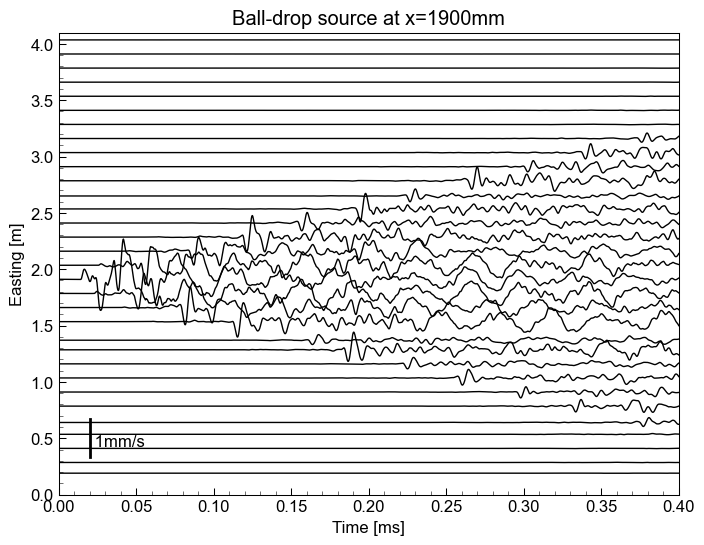

In [19]:
# for datacase in balldrop_ids:
print(datacase)
dataID = datacase.split('_')[1]
finame = os.path.join(datadir, datacase+".pickle") 


# read data
st = read(finame)

tpick = st.tpick
ot = st.origintime

#tvec with removing offset
fs = st_pick[0].stats.sampling_rate
t = st_pick[0].times()*1e3 - ot
#     t = np.arange(0, (st_pick[0].stats.npts-1)/fs, 1/fs)*1e3 - ot  #[ms]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
twin_max = 0.4 #[ms]
xlimit = [0, 0.4]
ylimit = [0, 4.1]

fontsize = 12
normamp = 3e-0
yshift = np.arange(0, len(st))
ylabels = []
for i, tr in enumerate(st):

    tr = st[i]
    stnm = tr.stats.station
    xloc = channel_loc[stnm][0]
#     ylabels.append(stnm)

    if channel_loc[stnm][1]<0:
        polarity = 1
    else:
        polarity = 1 # do not correct the polarity for simplicity
        
    picktime = tpick[stnm]
    ax.plot(t, polarity*tr.data*1e3/normamp + xloc/1e3, 'k-', lw=1) # in mm/s
#     ax.plot([picktime-ot, picktime-ot], [yshift[i]-0.5, yshift[i]+0.5],  color='r', ls='-', zorder=10)


ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.tick_params(direction='in')
# ax.set_yticks(yshift)
# ax.set_yticklabels(ylabels, fontsize=fontsize)
ax.set_xlabel("Time [ms]", fontsize=fontsize)
ax.set_ylabel("Easting [m]", fontsize=fontsize)
#     plt.gca().invert_yaxis()

# Plot scale
scale_len = 1 #[mm/s]
scale_x = 0.02
scale_y = 0.5
ax.plot([scale_x, scale_x],[scale_y-scale_len/2/normamp, scale_y+scale_len/2/normamp], "k-", lw=2)
ax.text(scale_x, scale_y-0.03, f" {scale_len}mm/s", va="center")

# ax.set_title("{} fs={}MHz no filtered".format(datacase, fs/1e6), fontsize=fontsize)
ax.set_title("Ball-drop source at x=1900mm")

plt.savefig(figdir_pick+"/alltraces_{}_forslide.png".format(datacase), format="png", dpi=70)


# Wiggles of all traces

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 28.41it/s]


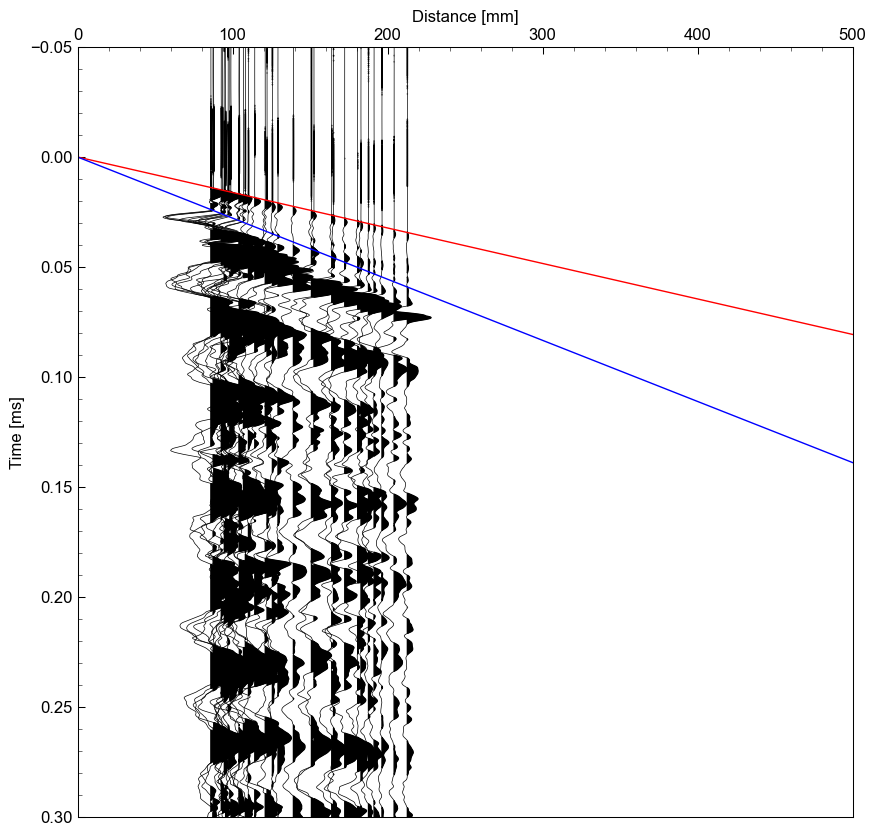

In [20]:
figdir_wiggle = "../figure/debug_p02_wiggles"

if not os.path.exists(figdir_wiggle):
    os.makedirs(figdir_wiggle)
    
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fontsize = 12
twin_max = .3 #[ms]
tlimit = [-0.05, twin_max]
xlimit = [0, 500] #[mm]
normamp = 3e-1
plotstationnum = 3

vp = 6200
vs = 3600 # 3700
vr = 0.92*vs # Rayleigh wave

colors = plt.cm.jet(np.linspace(0,1,len(balldrop_ids)))
# colors = plt.cm.tab20(np.linspace(0,1,len(balldrop_ids)))

for ic, datacase in enumerate(tqdm(balldrop_ids[::3])):
    # datacase = balldrop_ids[10]
    finame = os.path.join(datadir, datacase+".pickle") 

    # read data
    st = read(finame)

    tpick = st.tpick
    AEsensor_newloc = st.AEsensor_newloc
    ot = st.origintime

    # store traces for plots
    tpick_sorted = sorted(tpick.items(), key=lambda x: np.inf if np.isnan(x[1]) else x[1], reverse=False) # ignore the nan
#     tpick_sorted = sorted(tpick.items(), key=lambda x:x[1], reverse=False)

    st_wig = Stream()
    for i, (stnm, t1) in enumerate(tpick_sorted[:plotstationnum]):
        if np.isnan(t1):
            # skip this station
            continue;
        tr = st.select(station=stnm)[0]
        tr.dist = AEsensor_newloc[stnm][0]
        st_wig.append(tr)

    #tvec with removing offset
    fs = st_wig[0].stats.sampling_rate
    t = st_pick[0].times()*1e3 - ot
#     t = np.arange(0, (st_pick[0].stats.npts-1)/fs, 1/fs)*1e3 - ot  #[ms]

    for i in range(plotstationnum):

        tr = st_wig[i]
        stnm = tr.stats.station
        picktime = tpick[stnm]
        offset = tr.dist
        x1 = tr.data*1e4/normamp + offset
        ax.plot(x1, t, 'k-', lw = 0.5)
        ax.fill_betweenx(t,offset,x1,where=(x1>offset), color='k') #,color=colors[ic])

# plot theoretical arrival lines

xl = np.linspace(0, xlimit[1], 101)
ax.plot(xl, xl/vp, 'r-', lw=1.0)
ax.plot(xl, xl/vs, 'b-', lw=1.0)
# ax.plot(xl, xl/vr, 'g-', lw=1.0)

ax.set_xlim(xlimit)
ax.set_ylim(tlimit)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Distance [mm]", fontsize=fontsize)
ax.set_ylabel("Time [ms]", fontsize=fontsize)
ax.tick_params(direction='in')
plt.gca().invert_yaxis()

plt.savefig(figdir_wiggle+"/wiggles_all.png", format="png", dpi=150)


# Locations of ball drop

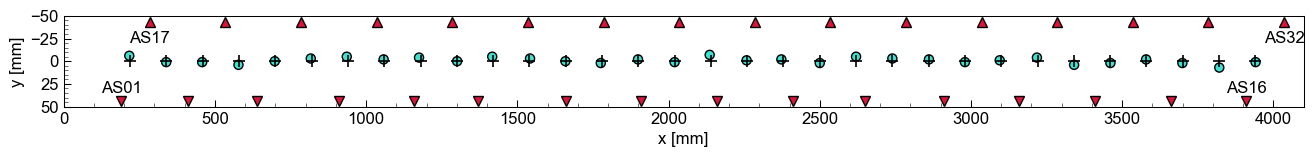

In [21]:
figdir_bdloc = "../figure/p02_relocated_balldrop_loc"

fontsize=16
if not os.path.exists(figdir_bdloc):
    os.makedirs(figdir_bdloc)
    
from matplotlib.patches import Rectangle, Circle, Ellipse

fig, ax = plt.subplots(1, 1, figsize=(16, 14))

left = 0 #[mm]
bottom = -50 #[mm]
width = 4100 #[mm]
height = 100 #[mm]
aspect_ratio = 3.0 # aspect ratio of rectangular plot

rect = Rectangle((left, bottom), width, height, fill=True, color='white')

ax.add_patch(rect)

# plot location from datacase

datacases = []
X_all = []
Y_all = []
Er_all = []

for datacase in balldrop_ids[::]:
#     datacase = balldrop_ids[10]
    dataID = datacase.split('_')[1]
    finame = os.path.join(datadir, datacase+".pickle") 

    # read data
    st = read(finame)

    [X, Y] = st.balldroploc
    V = st.velocity
    R = st.errvar

    # compute err radius
    terr = np.sqrt(R) # standard deviation sigma of arrival time [ms]
#     cradius = terr*vp #[ms*m/s = mm]

    # Fix c radius for visuallization
    cradius = 5#4.5
    # plot relocated source location
#     print([terr, X*1e3, Y*1e3])
    loc1 = Ellipse(xy=(X*1e3, Y*1e3), width=aspect_ratio*2*cradius, height=2*cradius, fc='turquoise', ec=None, alpha=1.0, zorder=1) #Circle((X*1e3, Y*1e3), radius=cradius, fc='w', ec='k')
    loc1ec = Ellipse(xy=(X*1e3, Y*1e3), width=aspect_ratio*2*cradius, height=2*cradius, fill=False, ec='k', lw=1.0, alpha=1.0, zorder=1) #Circle((X*1e3, Y*1e3), radius=cradius, fc='w', ec='k')
    ax.add_patch(loc1)
    ax.add_patch(loc1ec)

    # plot label location
    ax.plot(float(dataID), 0, marker='+', markersize=8, color='k', mew=1.2, zorder=2) 
    
    datacases.append(datacase)
    X_all.append(X)
    Y_all.append(Y)
    Er_all.append(R)

# plot location of stations
for stnm in channel_loc:
    x1 = channel_loc[stnm][0]
    y1 = channel_loc[stnm][1]
    z1 = channel_loc[stnm][2]
    # upper side
    if y1 >0:
        ax.plot(x1, y1-6, marker='v', markersize=7, color='crimson', mec='k')
    elif y1 < 0:
        ax.plot(x1, y1+7, marker='^', markersize=7, color='crimson', mec='k')

# Plot the sensor name
ax.text(channel_loc["OL01"][0], 35, "AS01", ha="center")
ax.text(channel_loc["OL16"][0], 35, "AS16", ha="center")
ax.text(channel_loc["OL17"][0], -20, "AS17", ha="center")
ax.text(channel_loc["OL32"][0], -20, "AS32", ha="center")

ax.set_xlim(left, width)
# ax.set_xlim(2820, 3200)
ax.set_ylim(bottom, height/2)
ax.set_yticks([-50, -25, 0, 25, 50])
ax.set_aspect(aspect_ratio)
plt.gca().invert_yaxis()

ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
plt.savefig(figdir_bdloc+"/FigS_balldrop_location.eps")
plt.savefig(figdir_bdloc+"/FigS_balldrop_location.png", dpi=70)


## Plot for the presentation

Text(0, 0.5, 'y [mm]')

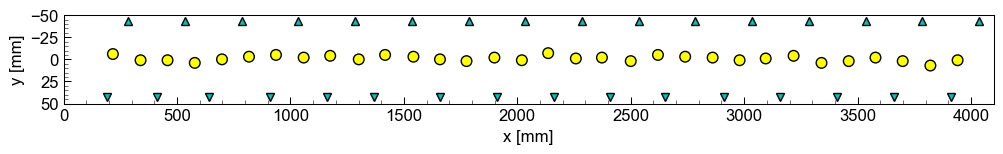

In [22]:
fontsize=16
if not os.path.exists(figdir_bdloc):
    os.makedirs(figdir_bdloc)
    
from matplotlib.patches import Rectangle, Circle, Ellipse

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

left = 0 #[mm]
bottom = -50 #[mm]
width = 4100 #[mm]
height = 100 #[mm]
aspect_ratio = 3.9 # aspect ratio of rectangular plot

rect = Rectangle((left, bottom), width, height, fill=True, color='white')

ax.add_patch(rect)

# plot location from datacase

datacases = []
X_all = []
Y_all = []
Er_all = []

for datacase in balldrop_ids[::]:
#     datacase = balldrop_ids[10]
    dataID = datacase.split('_')[1]
    finame = os.path.join(datadir, datacase+".pickle") 

    # read data
    st = read(finame)

    [X, Y] = st.balldroploc
    V = st.velocity
    R = st.errvar

    # compute err radius
    terr = np.sqrt(R) # standard deviation sigma of arrival time [ms]
#     cradius = terr*vp #[ms*m/s = mm]

    # Fix c radius for visuallization
    cradius = 6 #4.5
    # plot relocated source location
#     print([terr, X*1e3, Y*1e3])
    loc1 = Ellipse(xy=(X*1e3, Y*1e3), width=aspect_ratio*2*cradius, height=2*cradius, fc='yellow', ec=None, alpha=1.0, zorder=1) #Circle((X*1e3, Y*1e3), radius=cradius, fc='w', ec='k')
    loc1ec = Ellipse(xy=(X*1e3, Y*1e3), width=aspect_ratio*2*cradius, height=2*cradius, fill=False, ec='k', lw=1.0, alpha=1.0, zorder=1) #Circle((X*1e3, Y*1e3), radius=cradius, fc='w', ec='k')
    ax.add_patch(loc1)
    ax.add_patch(loc1ec)

    # plot label location
#     ax.plot(float(dataID), 0, marker='+', markersize=6, color='k', mew=1, zorder=2) 
    
    datacases.append(datacase)
    X_all.append(X)
    Y_all.append(Y)
    Er_all.append(R)

# plot location of stations
for stnm in channel_loc:
    x1 = channel_loc[stnm][0]
    y1 = channel_loc[stnm][1]
    z1 = channel_loc[stnm][2]
    # upper side
    if y1 >0:
        ax.plot(x1, y1-7, marker='v', markersize=6, color='c', mec='k')
    elif y1 < 0:
        ax.plot(x1, y1+7, marker='^', markersize=6, color='c', mec='k')

# Plot the sensor name
# ax.text(channel_loc["OL01"][0], 32, "OL01", ha="center")
# ax.text(channel_loc["OL16"][0], 32, "OL16", ha="center")
# ax.text(channel_loc["OL17"][0], -20, "OL17", ha="center")
# ax.text(channel_loc["OL32"][0], -20, "OL32", ha="center")

ax.set_xlim(left, width)
# ax.set_xlim(2820, 3200)
ax.set_ylim(bottom, height/2)
ax.set_yticks([-50, -25, 0, 25, 50])
ax.set_aspect(aspect_ratio)
plt.gca().invert_yaxis()

ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
# plt.savefig(figdir_bdloc+"/balldrop_location_slide.png")


### Plot only target location for introduction

In [23]:
len(balldrop_ids)

32

[0.0001802183381847015, 217.00000000000003, -6.000000000000005]
[0.00030089654436907807, 338.99999999999994, 1.0000000000000009]
[0.00035662011402624676, 457.99999999999994, 1.0000000000000009]
[4.0779872946295386e-05, 578.0000000000001, 3.9999999999999964]
[0.00010469536621516553, 698.0, 0.0]
[0.0001735417212164784, 817.0000000000001, -3.0000000000000027]
[0.00024751776436040754, 936.0, -5.000000000000004]
[6.997693411158154e-05, 1058.0, -2.0000000000000018]
[0.00014337361921248884, 1174.9999999999998, -4.0000000000000036]
[7.846045980670271e-05, 1301.0, 0.0]
[0.0004149807578335338, 1417.0000000000002, -5.000000000000004]
[5.920190963333283e-05, 1541.9999999999998, -3.0000000000000027]
[0.0004176807809658195, 1658.9999999999998, 0.0]
[0.00035730514746385876, 1775.9999999999998, 2.0000000000000018]
[0.0002556080866319896, 1898.9999999999998, -2.0000000000000018]
[0.0002833477977200522, 2020.0, 1.0000000000000009]
[5.960019620560008e-05, 2136.0, -6.999999999999999]
[0.000474478205765293

Text(0, 0.5, 'y [mm]')

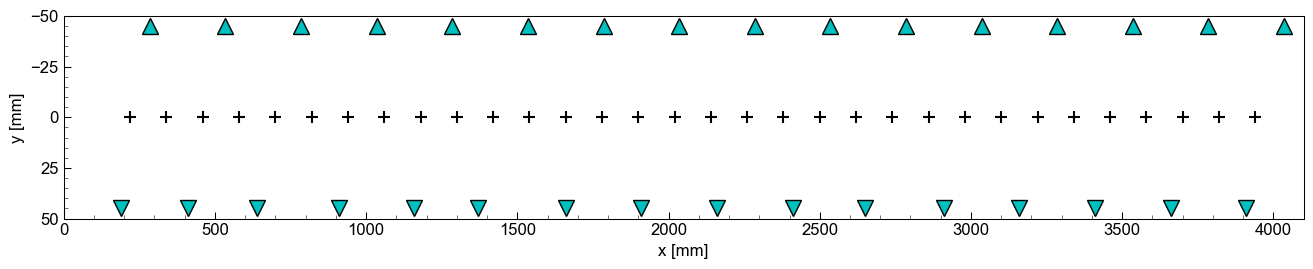

In [24]:
from matplotlib.patches import Rectangle, Circle, Ellipse
fontsize = 12

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

left = 0 #[mm]
bottom = -50 #[mm]
width = 4100 #[mm]
height = 100 #[mm]
aspect_ratio = 6.7 # aspect ratio of rectangular plot

rect = Rectangle((left, bottom), width, height, fill=True, color='white')

ax.add_patch(rect)

# plot location from datacase

datacases = []
X_all = []
Y_all = []
Er_all = []

for datacase in balldrop_ids[::]:
    
#     datacase = balldrop_ids[10]
    dataID = datacase.split('_')[1]
    finame = os.path.join(datadir, datacase+".pickle") 

    # read data
    st = read(finame)

    [X, Y] = st.balldroploc
    V = st.velocity
    R = st.errvar

    # compute err radius
    terr = np.sqrt(R) # standard deviation sigma of arrival time [ms]
#     cradius = terr*vp #[ms*m/s = mm]

    # Fix c radius for visuallization
    cradius = 3
    # plot relocated source location
    print([terr, X*1e3, Y*1e3])
#     loc1 = Ellipse(xy=(X*1e3, Y*1e3), width=aspect_ratio*2*cradius, height=2*cradius, fc='yellow', ec=None, alpha=0.6, zorder=10) #Circle((X*1e3, Y*1e3), radius=cradius, fc='w', ec='k')
#     loc1ec = Ellipse(xy=(X*1e3, Y*1e3), width=aspect_ratio*2*cradius, height=2*cradius, fill=False, ec='k', lw=1.0, alpha=1.0, zorder=11) #Circle((X*1e3, Y*1e3), radius=cradius, fc='w', ec='k')
#     ax.add_patch(loc1)
#     ax.add_patch(loc1ec)

    # plot label location
    ax.plot(float(dataID), 0, marker='+', markersize=8, color='k', mew=1.5) 
    
    datacases.append(datacase)
    X_all.append(X)
    Y_all.append(Y)
    Er_all.append(R)

# plot location of stations
for stnm in channel_loc:
    x1 = channel_loc[stnm][0]
    y1 = channel_loc[stnm][1]
    z1 = channel_loc[stnm][2]
    # upper side
    if y1 >0:
        ax.plot(x1, y1-5, marker='v', markersize=12, color='c', mec='k')
    elif y1 < 0:
        ax.plot(x1, y1+5, marker='^', markersize=12, color='c', mec='k')

ax.set_xlim(left, width)
ax.set_ylim(bottom, height/2)
ax.set_yticks([-50, -25, 0, 25, 50])
ax.set_aspect(aspect_ratio)
plt.gca().invert_yaxis()

ax.set_xlabel("x [mm]", fontsize=fontsize)
ax.set_ylabel("y [mm]", fontsize=fontsize)
# plt.savefig(figdir_bdloc+"/balldrop_location_onlytarget.png", format="png", dpi=150)
# plt.savefig(figdir_bdloc+"/balldrop_location_onlytarget.eps", format="eps", dpi=150)


In [25]:
for datacase in balldrop_ids[::]:
    
#     datacase = balldrop_ids[10]
    dataID = datacase.split('_')[1]
    print(float(dataID))

220.0
340.0
460.0
580.0
700.0
820.0
940.0
1060.0
1180.0
1300.0
1420.0
1540.0
1660.0
1780.0
1900.0
2020.0
2140.0
2260.0
2380.0
2500.0
2620.0
2740.0
2860.0
2980.0
3100.0
3220.0
3340.0
3460.0
3580.0
3700.0
3820.0
3940.0


In [26]:
X_all

[0.21700000000000003,
 0.33899999999999997,
 0.45799999999999996,
 0.5780000000000001,
 0.698,
 0.8170000000000001,
 0.936,
 1.058,
 1.1749999999999998,
 1.301,
 1.4170000000000003,
 1.5419999999999998,
 1.6589999999999998,
 1.7759999999999998,
 1.8989999999999998,
 2.02,
 2.136,
 2.258,
 2.373,
 2.5,
 2.62,
 2.74,
 2.861,
 2.98,
 3.095,
 3.218,
 3.341,
 3.4610000000000003,
 3.579,
 3.6990000000000003,
 3.821,
 3.941]

In [27]:
df_loc = pd.DataFrame({'datacase': datacases,
             'X' : np.round(X_all, 5) ,
             'Y' : np.round(Y_all, 5),
             'Z' : np.zeros(len(datacases)),
             'Er' : Er_all})

df_loc.to_csv("../data/balldrop_locations.csv")

In [28]:
X_all

[0.21700000000000003,
 0.33899999999999997,
 0.45799999999999996,
 0.5780000000000001,
 0.698,
 0.8170000000000001,
 0.936,
 1.058,
 1.1749999999999998,
 1.301,
 1.4170000000000003,
 1.5419999999999998,
 1.6589999999999998,
 1.7759999999999998,
 1.8989999999999998,
 2.02,
 2.136,
 2.258,
 2.373,
 2.5,
 2.62,
 2.74,
 2.861,
 2.98,
 3.095,
 3.218,
 3.341,
 3.4610000000000003,
 3.579,
 3.6990000000000003,
 3.821,
 3.941]

In [29]:
df_loc

,datacase,X,Y,Z,Er
0,BD_0220,0.217,-0.006,0.0,3.247865e-08
1,BD_0340,0.339,0.001,0.0,9.053873e-08
2,BD_0460,0.458,0.001,0.0,1.271779e-07
3,BD_0580,0.578,0.004,0.0,1.662998e-09
4,BD_0700,0.698,0.000,0.0,1.096112e-08
5,BD_0820,0.817,-0.003,0.0,3.011673e-08
6,BD_0940,0.936,-0.005,0.0,6.126504e-08
7,BD_1060,1.058,-0.002,0.0,4.896771e-09
8,BD_1180,1.175,-0.004,0.0,2.055599e-08
9,BD_1300,1.301,0.000,0.0,6.156044e-09


In [30]:
# plot best velocity value for each ball drop
from matplotlib.patches import Rectangle, Circle, Ellipse


# plot location from datacase
X = []
V = []

for datacase in tqdm(balldrop_ids[::]):
#     datacase = balldrop_ids[10]
    dataID = datacase.split('_')[1]
    finame = os.path.join(datadir, datacase+".pickle")
    # read data
    st = read(finame)
    [X1, Y1] = st.balldroploc
    X.append(X1)
    V.append(st.velocity)

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.83it/s]


Text(0, 0.5, 'Velocity [m/s]')

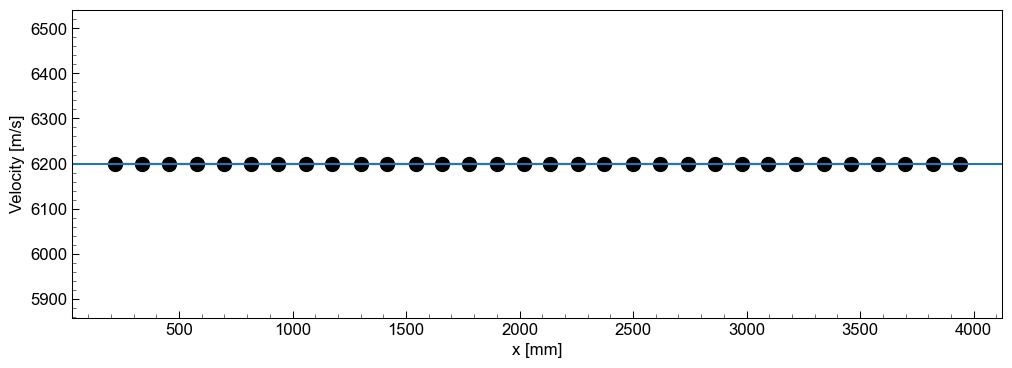

In [31]:
fontsize=12
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(np.array(X)*1e3, V, '-o', markersize=10, color='k', mec='k')
ax.axhline(6200)
# ax.set_xlim(left, width)
# ax.set_ylim(6350, 6450)
ax.set_xlabel("x [mm]", fontsize=fontsize)
ax.set_ylabel("Velocity [m/s]", fontsize=fontsize)
# plt.savefig(figdir_bdloc+"/balldrop_bestvelocity.png", format="png", dpi=150)

In [32]:
vmean = np.median(V)
vmean

6200.0